# Udacity Self-Driving Car Engineer Nanodegree Program
## Vehicle Detection Project
---
The goals / steps of this project are the following:

- Load Training Data 
- Visualize training set data
- Define Method to Convert Image to Histogram of Oriented Gradients (HOG)
- Define a function to compute Color Histogram features
- Define a function to return Spatial Binning of Color features 
- Define a function to extract features from a list of images
- Train and test the HOG Support Vector Classifier
- Train and test the Color Histogram Support Vector Classifier
- Train and the SVM classifier using all the features
- Sliding Window Implementation
- Adding Heatmaps and Bounding Boxes
- Pipeline to detect cars in a given frame
- Process video using the defined pipeline
- Add lane detection along with object detection and tracing


In [1]:
from skimage.feature import hog

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label

import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from moviepy.editor import VideoFileClip
from IPython.display import HTML

import numpy as np
import pickle
import cv2
import glob
import time

%matplotlib inline

### 1. Load Training Data    

In [2]:
car_images = glob.glob('data/vehicles/**/*.png')
noncar_images = glob.glob('data/non-vehicles/**/*.png')
print(len(car_images), len(noncar_images))

8792 8968


### 2. Visualize training set data

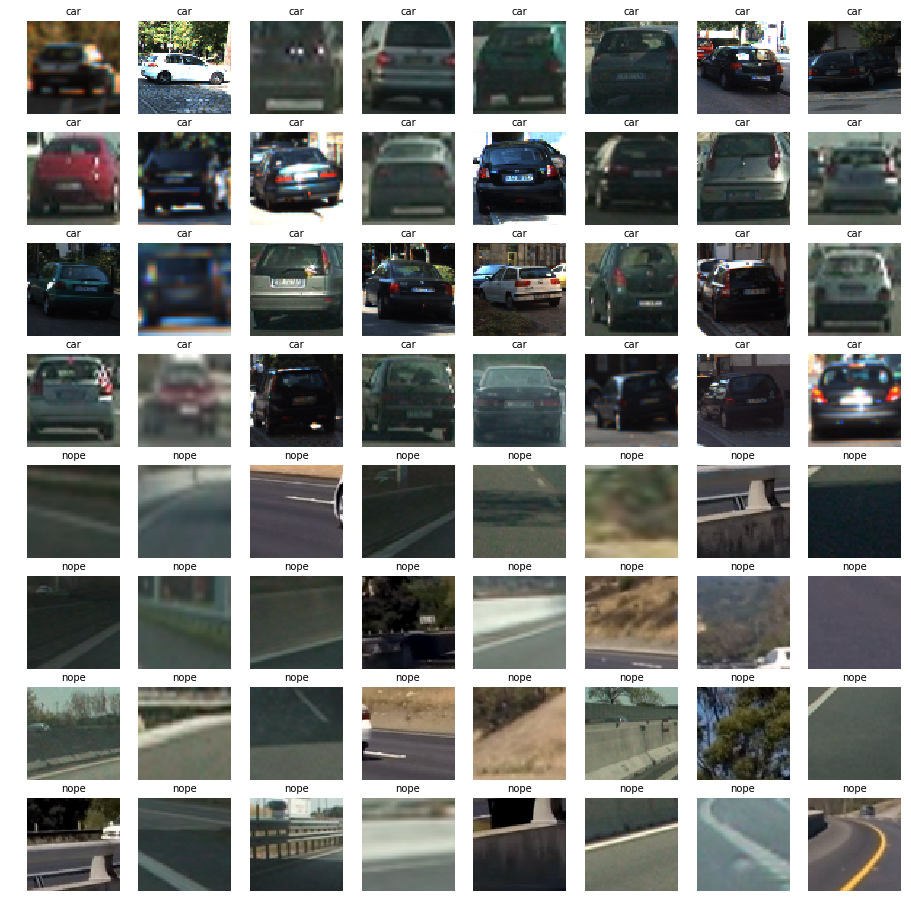

In [3]:
fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(32):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(32,64):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('nope', fontsize=10)
    axs[i].imshow(img)
    
#fig.savefig('output_images/training_sample.png', bbox_inches="tight")

### 3. Define Method to Convert Image to Histogram of Oriented Gradients (HOG)
*This method was duplicated from lesson materials*

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

#### Visualize HOG on sample set of training image

In [5]:
orient = 9
pix_per_cell = 8
cell_per_block = 8

car1 = mpimg.imread(car_images[2])
_,car1_dst = get_hog_features(car1[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
car2 = mpimg.imread(car_images[15])
_,car2_dst = get_hog_features(car2[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

noncar1 = mpimg.imread(noncar_images[5])
_,noncar1_dst = get_hog_features(noncar1[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
noncar2 = mpimg.imread(noncar_images[15])
_,noncar2_dst = get_hog_features(noncar2[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

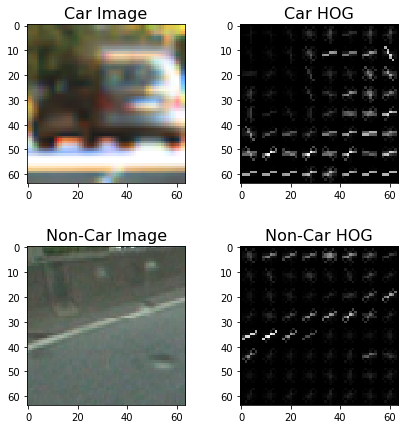

In [6]:
# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car1)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car1_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar1)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar1_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)

#f.savefig('output_images/hog_sample_1.png', bbox_inches="tight")

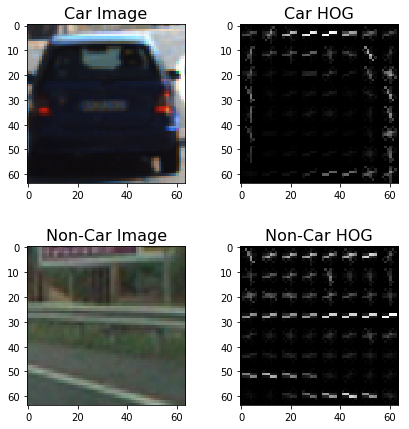

In [7]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car2)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car2_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar2)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar2_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)

#f.savefig('output_images/hog_sample_2.png', bbox_inches="tight")

### 4. Defining a function to compute Color Histogram features
*The code for this method was mostly duplicated from course lesson material.*

In [8]:
# Define a function to compute color histogram features
def color_hist(img, nbins=32, bins_range=(0, 256), vis=False):
    
    bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Generating bin centers
    bin_edges = channel1_hist[1] #all three bins are the same size
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges) - 1])/2
    
    hist_features = np.concatenate((channel1_hist[0],
                                    channel2_hist[0],
                                    channel3_hist[0]))
    if vis == True:
        return channel1_hist, channel2_hist, channel3_hist, bin_centers
    else:
        return hist_features

#### Visualize 

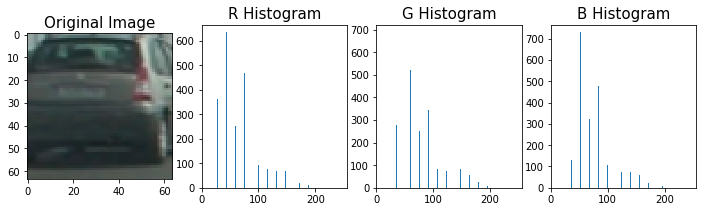

In [9]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(car_images))
# Read in the image
img = cv2.imread(car_images[ind])
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Compute color histogram features of the test image
channel1_hist, channel2_hist, channel3_hist, bin_centers = color_hist(image, vis=True)
# Plot the examples
fig = plt.figure(figsize=(12,3));

plt.subplot(141)
plt.imshow(image)
plt.title('Original Image', fontsize=15)
plt.subplot(142)
plt.bar(bin_centers, channel1_hist[0])
plt.xlim(0, 256)
plt.title('R Histogram', fontsize=15);
plt.subplot(143)
plt.bar(bin_centers, channel2_hist[0])
plt.xlim(0, 256)
plt.title('G Histogram', fontsize=15);
plt.subplot(144)
plt.bar(bin_centers, channel3_hist[0])
plt.xlim(0, 256)
plt.title('B Histogram', fontsize=15);

#plt.savefig('output_images/color_hist_vis.png', bbox_inches="tight")

### 5. Defining a function to return Spatial Binning of Color features 

In [10]:
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

#### Visualize 

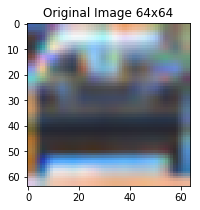

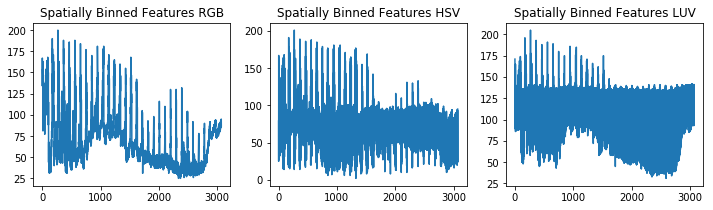

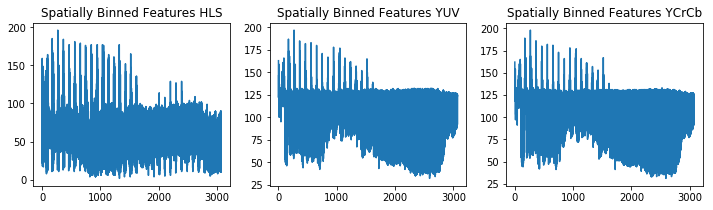

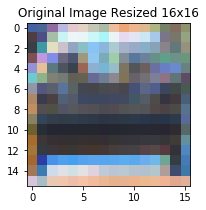

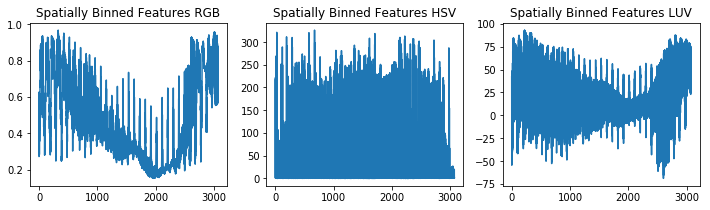

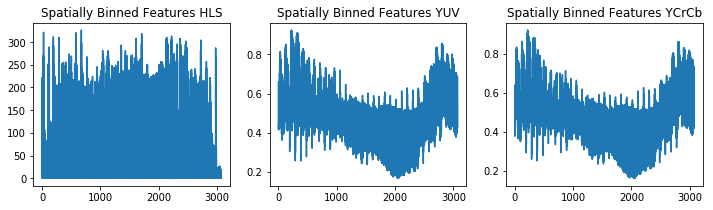

In [11]:
feature_vec1 = bin_spatial(image, color_space='RGB', size=(32, 32))
feature_vec2 = bin_spatial(image, color_space='HSV', size=(32, 32))
feature_vec3 = bin_spatial(image, color_space='LUV', size=(32, 32))
feature_vec4 = bin_spatial(image, color_space='HLS', size=(32, 32))
feature_vec5 = bin_spatial(image, color_space='YUV', size=(32, 32))
feature_vec6 = bin_spatial(image, color_space='YCrCb', size=(32, 32))

# Read in an image
# You can also read cutout2, 3, 4 etc. to see other examples
ind = np.random.randint(0, len(car_images))
# Read in the image
image = mpimg.imread(car_images[ind])
small_image = cv2.resize(image, (16, 16))

# Plot features
fig = plt.figure(figsize=(12,3))
plt.subplot(111)
plt.imshow(image)
plt.title('Original Image 64x64')
#plt.savefig('output_images/bin_spatial1.png', bbox_inches="tight")

fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.plot(feature_vec1)
plt.title('Spatially Binned Features RGB')
plt.subplot(132)
plt.plot(feature_vec2)
plt.title('Spatially Binned Features HSV')
plt.subplot(133)
plt.plot(feature_vec3)
plt.title('Spatially Binned Features LUV')
#plt.savefig('output_images/bin_spatial2.png', bbox_inches="tight")

fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.plot(feature_vec4)
plt.title('Spatially Binned Features HLS')
plt.subplot(132)
plt.plot(feature_vec5)
plt.title('Spatially Binned Features YUV')
plt.subplot(133)
plt.plot(feature_vec6)
plt.title('Spatially Binned Features YCrCb')
#plt.savefig('output_images/bin_spatial3.png', bbox_inches="tight")

feature_vec11 = bin_spatial(small_image, color_space='RGB', size=(32, 32))
feature_vec12 = bin_spatial(small_image, color_space='HSV', size=(32, 32))
feature_vec13 = bin_spatial(small_image, color_space='LUV', size=(32, 32))
feature_vec14 = bin_spatial(small_image, color_space='HLS', size=(32, 32))
feature_vec15 = bin_spatial(small_image, color_space='YUV', size=(32, 32))
feature_vec16 = bin_spatial(small_image, color_space='YCrCb', size=(32, 32))

# Plot features
fig = plt.figure(figsize=(12,3))
plt.subplot(111)
plt.imshow(small_image)
plt.title('Original Image Resized 16x16')
#plt.savefig('output_images/bin_spatial11.png', bbox_inches="tight")

fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.plot(feature_vec11)
plt.title('Spatially Binned Features RGB')
plt.subplot(132)
plt.plot(feature_vec12)
plt.title('Spatially Binned Features HSV')
plt.subplot(133)
plt.plot(feature_vec13)
plt.title('Spatially Binned Features LUV')
#plt.savefig('output_images/bin_spatial22.png', bbox_inches="tight")

fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.plot(feature_vec14)
plt.title('Spatially Binned Features HLS')
plt.subplot(132)
plt.plot(feature_vec15)
plt.title('Spatially Binned Features YUV')
plt.subplot(133)
plt.plot(feature_vec16)
plt.title('Spatially Binned Features YCrCb')
#plt.savefig('output_images/bin_spatial33.png', bbox_inches="tight")

### 6. Defining a function to extract features from a list of images

In [12]:
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(images, color_space='RGB', spatial_size=(32, 32), 
                     hist_bins=32, orient=9, pix_per_cell=8,
                     cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in tqdm(images):
        file_features = []
        img = mpimg.imread(file) # idea for the progress came from "nhiddink"
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)
            
        if spatial_feat == True:
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist() also with a color space option now
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                pix_per_cell, cell_per_block, vis=False,
                                                feature_vec=True)
            file_features.append(hog_features)
        # Append the new feature vector to the features list
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### 7. Training and testing the HOG Support Vector Classifier

In [13]:
car_features = extract_features(car_images, hog_feat=True)
notcar_features = extract_features(noncar_images, hog_feat=True)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y,
                                                    test_size=0.2,
                                                    random_state=rand_state)
# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC

svc.fit(X_train, y_train)

print('Feature vector length:', len(X_train[0]))

100%|██████████| 8968/8968 [00:12<00:00, 720.36it/s]


Feature vector length: 4932


In [14]:
print('Test Accuracy of SVC: {0:.2f}%'.format(round(svc.score(X_test, y_test)*100, 4)))
print('  Predictions:', svc.predict(X_test[0:10]))
print('       Labels:', y_test[0:10])


Test Accuracy of SVC: 96.34%
  Predictions: [ 0.  1.  1.  1.  1.  1.  0.  0.  0.  0.]
       Labels: [ 0.  1.  1.  1.  1.  1.  0.  0.  0.  0.]


### 8. Training and testing the Color Histogram Support Vector Classifier

In [15]:
car_features = extract_features(car_images, spatial_feat=True, hist_feat=True)
notcar_features = extract_features(noncar_images, spatial_feat=True, hist_feat=True)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y,
                                                    test_size=0.2,
                                                    random_state=rand_state)
# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC

svc.fit(X_train, y_train)

print('Feature vector length:', len(X_train[0]))

100%|██████████| 8968/8968 [00:12<00:00, 724.63it/s]


Feature vector length: 4932


In [16]:
print('Test Accuracy of SVC: {0:.2f}%'.format(round(svc.score(X_test, y_test)*100, 4)))
print('  Predictions:', svc.predict(X_test[0:10]))
print('       Labels:', y_test[0:10])

Test Accuracy of SVC: 97.27%
  Predictions: [ 0.  0.  1.  1.  1.  1.  0.  1.  0.  0.]
       Labels: [ 0.  0.  1.  1.  1.  1.  1.  1.  0.  0.]


### 9. Train the combined classifier and test the predictions

In [17]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 64   # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(car_images, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat,
                            hog_feat=hog_feat)
notcar_features = extract_features(noncar_images, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat,
                            hog_feat=hog_feat)

100%|██████████| 8968/8968 [00:27<00:00, 329.63it/s]


In [18]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
#rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2,
                                                    random_state=rand_state)

print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()

svc.fit(X_train, y_train)

# Check the score of the SVC
print('Test Accuracy of SVC = {0:.2f}%'.format(round(svc.score(X_test, y_test)*100, 4)))


Feature vector length: 9144
Test Accuracy of SVC = 99.04%


### Method to Draw Rectangles onto an Image
*Duplicated from lesson material*

In [19]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

## 10. Sliding Window Implementation

In [20]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                 xy_window=(128, 128), #(64, 64), (96, 96)
                 xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

### Show All Potential Search Areas

Becuase the size and position of cars in the image will be different depending on their distance from the camera, Experimenting with different `ystart`, `ystop`, and `scale` values. These next few blocks of code are for determining the values for these parameters that work best.

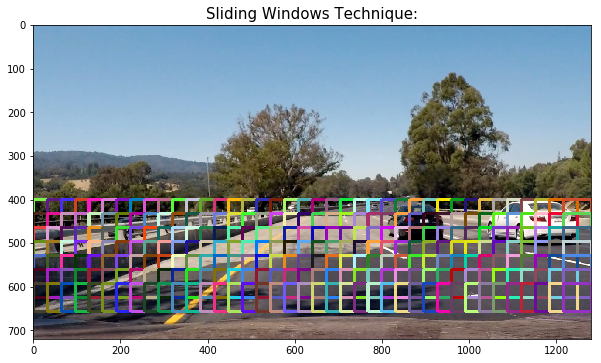

In [21]:
test_img = mpimg.imread('test_images/test4.jpg')

windows =  slide_window(test_img,
                        x_start_stop=[None, None],
                        y_start_stop=[400, 656], #tune the parameters
                        xy_window=(64, 64),
                        xy_overlap=(0.5, 0.5))

window_img = draw_boxes(test_img, windows, color='random')
plt.figure(figsize=(10,10))
plt.imshow(window_img);
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)

plt.title('Sliding Windows Technique:', fontsize=15);
#plt.savefig('output_images/sliding_windows_64.png', bbox_inches="tight")

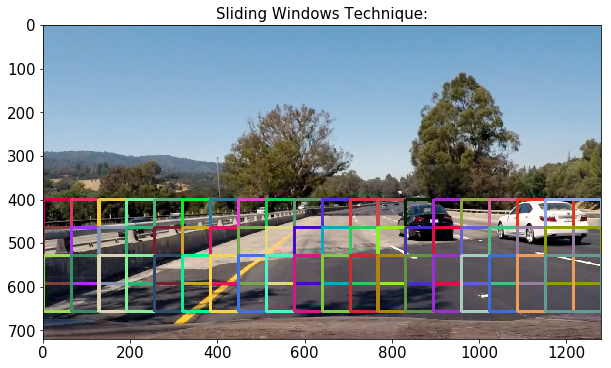

In [22]:
windows =  slide_window(test_img,
                        x_start_stop=[None, None],
                        y_start_stop=[400, 656], #tune the parameters
                        xy_window=(128, 128),
                        xy_overlap=(0.5, 0.5))

window_img = draw_boxes(test_img, windows, color='random')
plt.figure(figsize=(10,10))
plt.imshow(window_img);
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)

plt.title('Sliding Windows Technique:', fontsize=15);
#plt.savefig('output_images/sliding_windows_64.png', bbox_inches="tight")

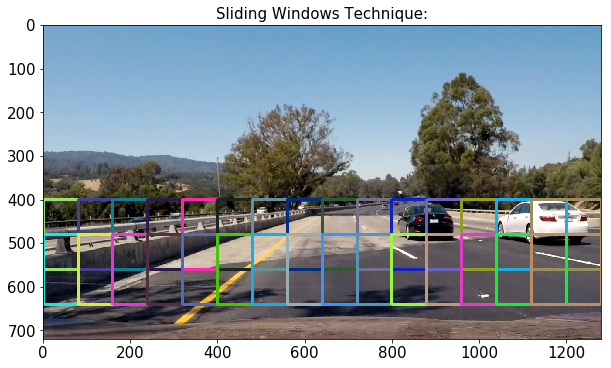

In [23]:
windows =  slide_window(test_img,
                        x_start_stop=[None, None],
                        y_start_stop=[400, 656], #tune the parameters
                        xy_window=(160, 160),
                        xy_overlap=(0.5, 0.5))

window_img = draw_boxes(test_img, windows, color='random')
plt.figure(figsize=(10,10))
plt.imshow(window_img);
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)

plt.title('Sliding Windows Technique:', fontsize=15);
#plt.savefig('output_images/sliding_windows_64.png', bbox_inches="tight")

## 11. Defining a function to extract features from a single image 

In [24]:
# This function is very similar to extract_features()
# just for a single image rather than list of images
def extract_image_features(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                            pix_per_cell, cell_per_block,
                                            vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)

### Define a fucntion to search for sub images within the search region

In [25]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                   spatial_size=(32, 32), hist_bins=32, orient=9, 
                   pix_per_cell=8, cell_per_block=2, hog_channel=0,
                   spatial_feat=True, hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    image_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extract_image_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            image_windows.append(window)
    #8) Return windows for positive detections
    return image_windows

In [26]:
def detect_cars_in_image(image):

    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    windows =  slide_window(test_img,
                            x_start_stop=[600, None],
                            y_start_stop=[400, 656], #tune the parameters
                            xy_window=(128,128),
                            xy_overlap=(.7,.7))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color='random') 
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,9))
    plt.tight_layout()
    ax1.imshow(draw_image)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(window_img)
    ax2.set_title('Cars found', fontsize=30)
    #plt.savefig('output_images/windows.png', bbox_inches="tight")

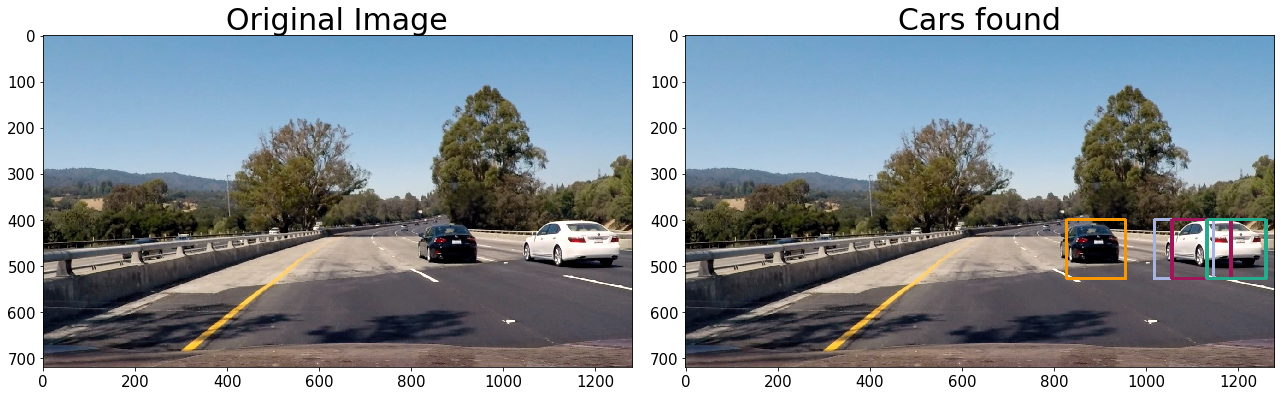

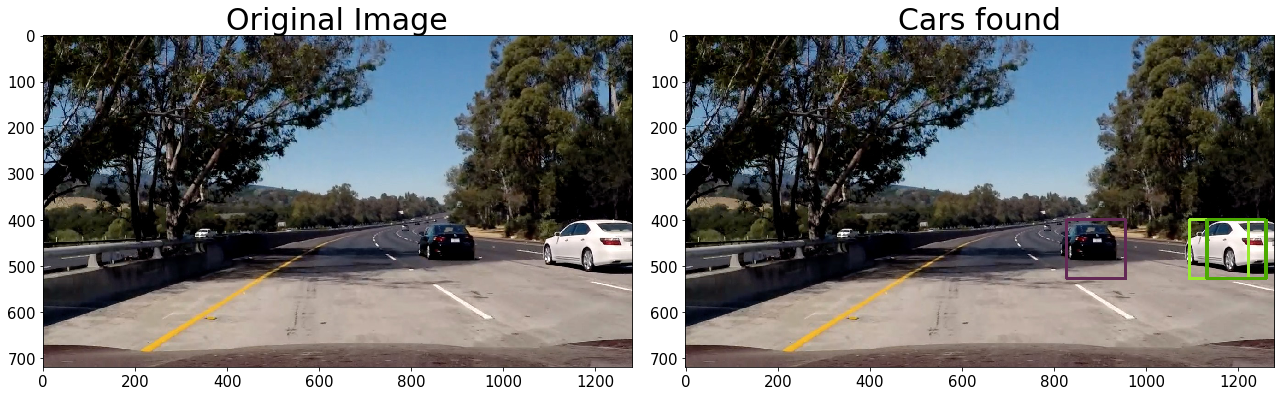

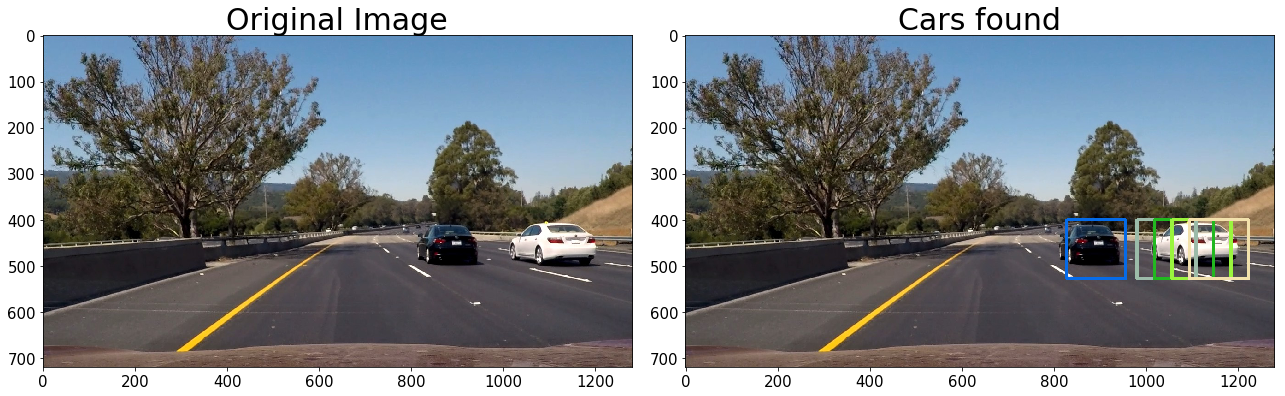

In [27]:
image_list = ['test_images/test4.jpg',
         'test_images/test5.jpg',
         'test_images/test6.jpg']
for fname in image_list:
    detect_cars_in_image(mpimg.imread(fname))

## 12. Adding Heatmaps and Bounding Boxes

In [28]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 8)
    # Return the image
    return img

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

## 13. Defining a function that can extract features and make predictions

In [29]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler,
              orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch,
                                     (np.int(imshape[1]/scale),
                                      np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list=[] #https://github.com/preritj/Vechicle-Detection-Tracking
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features,
                                                          hist_features,
                                                          hog_features)).reshape(1, -1))  
            
            # Scale features and make a prediction  
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart),
                              (255,0,0),8)
                bbox_list.append(((xbox_left, ytop_draw+ystart), #github.com/preritj
                                  (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    
    return bbox_list

## 14. Heatmap Testing

In [30]:
def adv_detect_cars_in_image(img):    

    orient=10
    pix_per_cell=8
    cell_per_block=2
    spatial_size=(32, 32)
    hist_bins=64
    
    bbox_list = []
    
    
    ystart = 380
    ystop = 550
    scale = 1.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 600
    scale = 1.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 656
    scale = 2.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
   
    # Copied from 'jeremy-shannon'
    bbox_list = [item for sublist in bbox_list for item in sublist] 
    
    out_img = draw_boxes(img, bbox_list, color='random')
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox_list)
    heat = apply_threshold(heat, 2)  

    # Find final boxes from heatmap using label function
    labels = label(heat)
    new_img = draw_labeled_bboxes(np.copy(img), labels)

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,9))
    plt.tight_layout()
    ax1.imshow(out_img)
    ax1.set_title('Search Boxes', fontsize=30)
    ax2.imshow(heat, cmap='hot')
    ax2.set_title('Heat Map', fontsize=30)
    ax3.imshow(new_img)
    ax3.set_title('Bounding Boxes', fontsize=30)
    #plt.savefig('output_images/heat_map1.png', bbox_inches="tight")

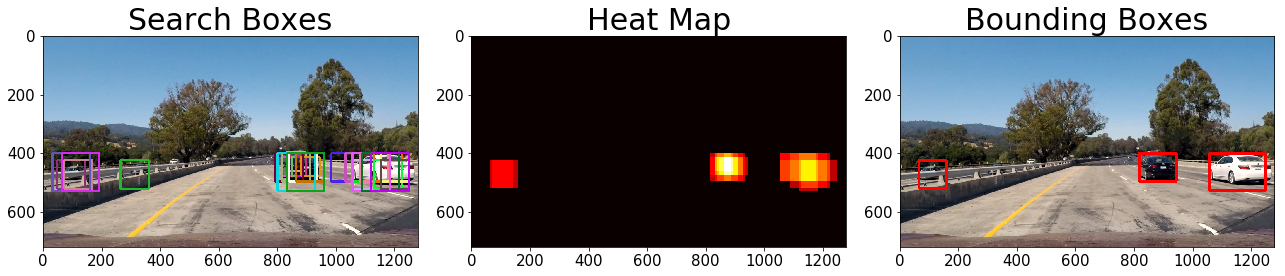

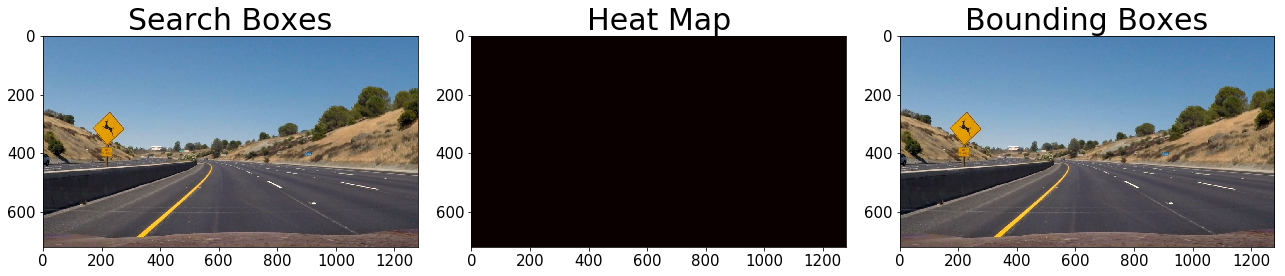

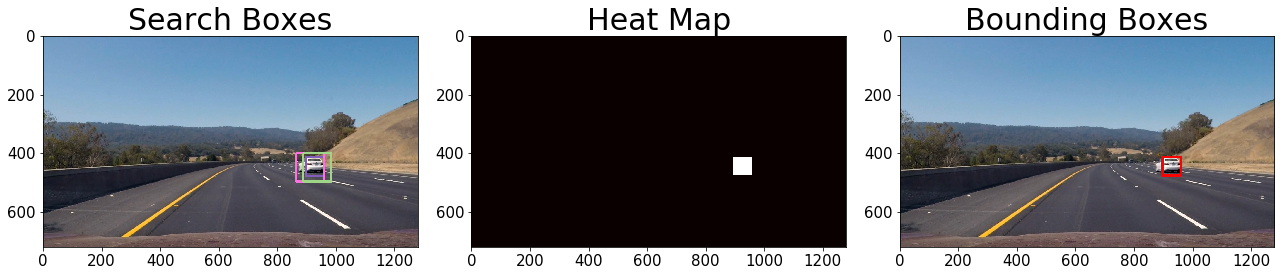

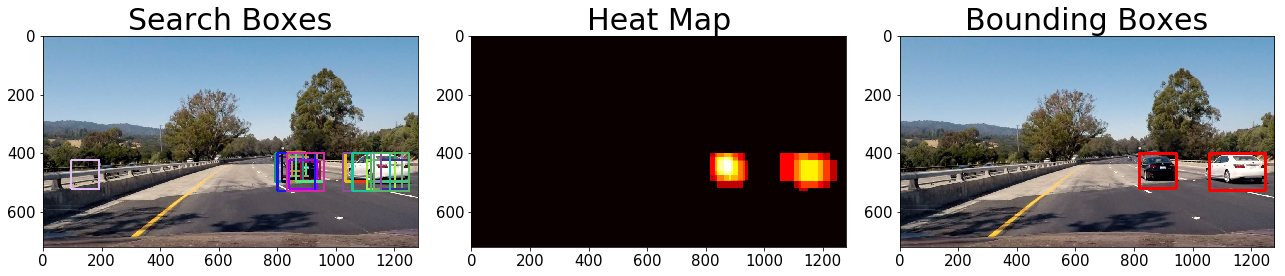

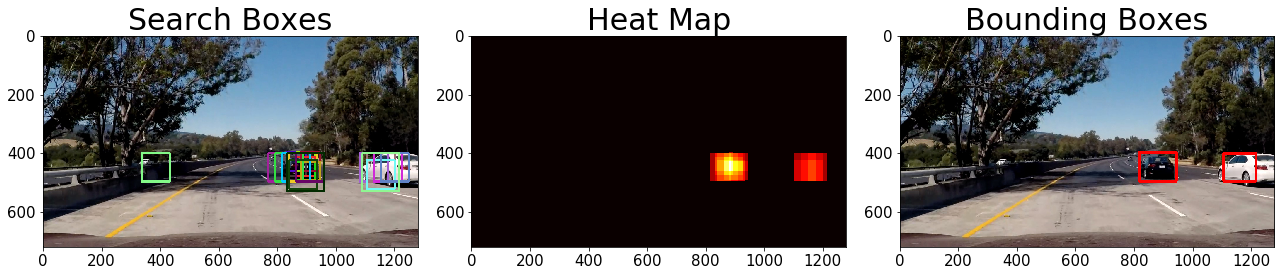

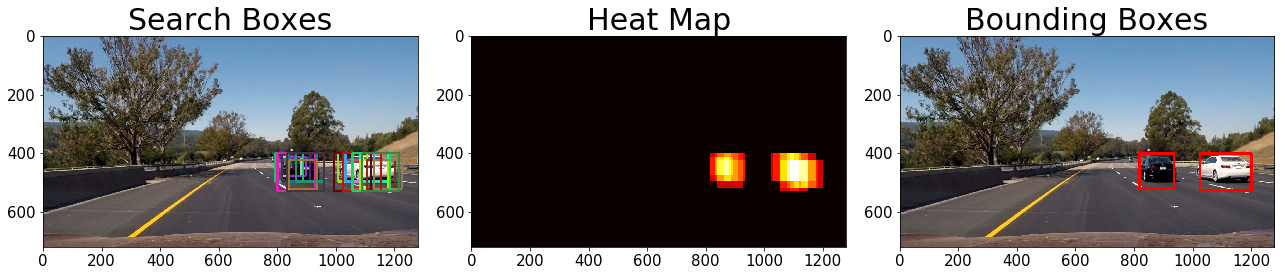

In [31]:
img_list = ['test_images/test1.jpg',
            'test_images/test2.jpg',
            'test_images/test3.jpg',
            'test_images/test4.jpg',
            'test_images/test5.jpg',
            'test_images/test6.jpg']

for fname in img_list:
    adv_detect_cars_in_image(mpimg.imread(fname))

In [32]:
# Define a class to store data from video
from collections import deque
class Vehicle_Detect_History():
    def __init__(self):
        # history of rectangles previous n frames
        self.history = deque(maxlen = 8)
        
    def add_to_history(self, rects):
        self.history.append(rects)

## Pipeline to detect cars in a given frame

In [33]:
def pipeline_final(img):

    orient=10
    pix_per_cell=8
    cell_per_block=2
    spatial_size=(32, 32)
    hist_bins=64
    
    bbox_list = []
    
    ystart = 380
    ystop = 550
    scale = 1.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 600
    scale = 1.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 656
    scale = 2.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))

    ystart = 400
    ystop = 660
    scale = 3.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    '''
    ystart = 400
    ystop = 464
    scale = 1.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    ystart = 416
    ystop = 480
    scale = 1.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    ystart = 400
    ystop = 496
    scale = 1.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    ystart = 432
    ystop = 528
    scale = 1.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    ystart = 400
    ystop = 528
    scale = 2.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    ystart = 432
    ystop = 560
    scale = 2.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    ystart = 400
    ystop = 596
    scale = 3.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    ystart = 464
    ystop = 660
    scale = 3.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    '''
    
    bbox_list = [item for sublist in bbox_list for item in sublist] 
    
    #heatmap_img = np.zeros_like(img[:,:,0]).astype(np.float)
    #heatmap_img = add_heat(heat, bbox_list)
    #heatmap_img = apply_threshold(heat, 2)  
    
    # add detections to the history
    if len(bbox_list) > 0:
        det.add_to_history(bbox_list)
    
    heatmap_img = np.zeros_like(img[:,:,0]).astype(np.float)
    for rectangles in det.history:
        heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(det.history)//2)
     
    # Find final boxes from heatmap using label function
    labels = label(heatmap_img)
    new_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return new_img

# Video Ouput

In [34]:
det = Vehicle_Detect_History()

test_output = "test_video_output.mp4"
clip = VideoFileClip("test_video.mp4")
test_clip = clip.fl_image(pipeline_final)
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:21<00:00,  1.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 34.8 s, sys: 119 ms, total: 34.9 s
Wall time: 22.2 s


In [35]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

In [36]:
det = Vehicle_Detect_History()

output = "project_video_output.mp4"
clip = VideoFileClip("project_video.mp4")
clip = clip.fl_image(pipeline_final)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [12:00<00:00,  1.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 19min 12s, sys: 1.93 s, total: 19min 14s
Wall time: 12min 1s


In [37]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

## Combining Lane finding and object detection into one pipeline

https://santhoshpkumar.github.io/AdvancedFindingLaneLinesOnTheRoad/

In [38]:
# compute the camera calibration using chessboard images
def compute_calibration_coeff():
    nx = 9
    ny = 6

    objpoints = []
    imgpoints = []

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    for i in range(len(images)):
        img = cv2.imread(images[i])
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    return (objpoints, imgpoints)

In [39]:
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
image_shape = mpimg.imread('./camera_cal/calibration1.jpg').shape
objpoints, imgpoints = compute_calibration_coeff()
# use the object and image points to caliberate the camera and 
# compute the camera matrix and distortion coefficients
ret, cameraMatrix, distortionCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, 
                                                                        imgpoints, 
                                                                        image_shape[:2],
                                                                        None,None)

In [40]:
# Function to undistort the camera image
def undistort_image(image):
    return cv2.undistort(image, cameraMatrix, distortionCoeffs, None, cameraMatrix)

In [41]:
def straight_threshold(gray, orient='x', thresh_min=0, thresh_max=255):
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    max_value = np.max(abs_sobel)
    binary_output = np.uint8(255*abs_sobel/max_value)
    threshold_mask = np.zeros_like(binary_output)
    threshold_mask[(binary_output >= thresh_min) & (binary_output <= thresh_max)] = 1
    return threshold_mask

def angled_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobel_y,abs_sobel_x)
    direction = np.absolute(direction)
    # 5) Create a binary mask where direction thresholds are met
    mask = np.zeros_like(direction)
    mask[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mask

In [42]:
def threshold_image(img):
    
    # apply undistory pipeline
    img = undistort_image(img)
    
    # convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    height, width = gray.shape
    
    # apply gradient threshold on the horizontal gradient
    sx_binary = straight_threshold(gray, 'x', 10, 200)
    
    # apply gradient direction threshold so that only edges closer to vertical are detected.
    dir_binary = angled_threshold(gray, thresh=(np.pi/6, np.pi/2))
    
    # combine the gradient and direction thresholds.
    combined_condition = ((sx_binary == 1) & (dir_binary == 1))
    
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    
    
    # color channel thresholds
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    # S channel performs well for detecting bright yellow and white lanes
    s_thresh = (100, 255)
    s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])
    
    # We put a threshold on the L channel to avoid pixels which have shadows and as a result darker.
    l_thresh = (120, 255)
    l_condition = (L > l_thresh[0]) & (L <= l_thresh[1])

    # combine all the thresholds
    # A pixel should either be a yellowish or whiteish
    # And it should also have a gradient, as per our thresholds
    color_combined[(r_g_condition & l_condition) & (s_condition | combined_condition)] = 1
    
    # apply the region of interest mask
    mask = np.zeros_like(color_combined)
    region_of_interest_vertices = np.array([[0,height-1], 
                                            [width/2, int(0.5*height)], 
                                            [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(color_combined, mask)
    
    return thresholded

In [43]:
src_bottom_left = [220,720]
src_bottom_right = [1110, 720]
src_top_left = [570, 470]
src_top_right = [722, 470]

dst_bottom_left = [320,720]
dst_bottom_right = [920, 720]
dst_top_left = [320, 1]
dst_top_right = [920, 1]

src = np.float32([src_bottom_left,src_bottom_right,src_top_right,src_top_left])
dst = np.float32([dst_bottom_left,dst_bottom_right,dst_top_right,dst_top_left])

M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)

def warp_image(image):
    copy = image.copy()
    image_shape = image.shape

    img_size = (image_shape[1], image_shape[0])
    warped = cv2.warpPerspective(threshold_image(copy), M, img_size , flags=cv2.INTER_LINEAR)
    return warped

In [44]:
# Some global variables
polyfit_left=None
polyfit_right=None

past_good_left_lines = []
past_good_right_lines = []

running_mean_difference_between_lines = 0

def get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows):
    """
        Given ncoordinates of non-zeros pixels and coordinates of non-zeros pixels within the sliding windows,
        this function generates a prediction for the lane line.
    """
    left_x = non_zeros_x[left_coordinates]
    left_y = non_zeros_y[left_coordinates]
    
    # If no pixels were found return None
    if(left_y.size == 0 or left_x.size == 0):
        return None, None

    # Fit the polynomial
    polyfit_left = np.polyfit(left_y, left_x, 2)

    right_x = non_zeros_x[right_coordinates]
    right_y = non_zeros_y[right_coordinates]
    
    # If no pixels were found return None
    if(right_y.size == 0 or right_x.size == 0):
        return None, None

    # Fit the polynomial
    polyfit_right = np.polyfit(right_y, right_x, 2)

    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    
    # Generate the lane lines from the polynomial fit
    left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]
    right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]
    
    return left_x_predictions, right_x_predictions

def brute_search(warped):
    """
        This function searches for lane lines from scratch.
        Thresholding & performing a sliding window search.
    """
    non_zeros = warped.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    
    num_rows = warped.shape[0]
    
    histogram = np.sum(warped[np.int(warped.shape[0]/2):,:], axis=0)

    half_width = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:half_width])
    rightx_base = np.argmax(histogram[half_width:]) + half_width

    num_windows = 10
    window_height = np.int(num_rows/num_windows)
    window_half_width = 50

    min_pixels = 100

    left_coordinates = []
    right_coordinates = []

    for window in range(num_windows):
        y_max = num_rows - window*window_height
        y_min = num_rows - (window+1)* window_height

        left_x_min = leftx_base - window_half_width
        left_x_max = leftx_base + window_half_width

        good_left_window_coordinates = ((non_zeros_x >= left_x_min) & 
                                        (non_zeros_x <= left_x_max) & 
                                        (non_zeros_y >= y_min) & 
                                        (non_zeros_y <= y_max)).nonzero()[0]
        left_coordinates.append(good_left_window_coordinates)

        if len(good_left_window_coordinates) > min_pixels:
            leftx_base = np.int(np.mean(non_zeros_x[good_left_window_coordinates]))

        right_x_min = rightx_base - window_half_width
        right_x_max = rightx_base + window_half_width

        good_right_window_coordinates = ((non_zeros_x >= right_x_min) & 
                                         (non_zeros_x <= right_x_max) & 
                                         (non_zeros_y >= y_min) & 
                                         (non_zeros_y <= y_max)).nonzero()[0]
        right_coordinates.append(good_right_window_coordinates)

        if len(good_right_window_coordinates) > min_pixels:
            rightx_base = np.int(np.mean(non_zeros_x[good_right_window_coordinates]))

    left_coordinates = np.concatenate(left_coordinates)
    right_coordinates = np.concatenate(right_coordinates)
    
    left_x_predictions, right_x_predictions = get_line_predictions(non_zeros_x, 
                                                                   non_zeros_y, 
                                                                   left_coordinates, 
                                                                   right_coordinates, 
                                                                   num_rows)
    return left_x_predictions, right_x_predictions

def get_averaged_line(previous_lines, new_line):
    """
        This function computes an averaged lane line by averaging over previous good frames.
    """
    
    # Number of frames to average over
    num_frames = 12
    
    if new_line is None:
        # No line was detected
        
        if len(previous_lines) == 0:
            # If there are no previous lines, return None
            return previous_lines, None
        else:
            # Else return the last line
            return previous_lines, previous_lines[-1]
    else:
        if len(previous_lines) < num_frames:
            # we need at least num_frames frames to average over
            previous_lines.append(new_line)
            return previous_lines, new_line
        else:
            # average over the last num_frames frames
            previous_lines[0:num_frames-1] = previous_lines[1:]
            previous_lines[num_frames-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(num_frames):
                new_line += previous_lines[i]
            new_line /= num_frames
            return previous_lines, new_line
        
        
def get_mean_distance_between_lines(left_line, right_line, running_average):
    """
        Returns running weighted average of simple difference between left and right lines
    """
    mean_distance = np.mean(right_line - left_line)
    if running_average == 0:
        running_average = mean_distance
    else:
        running_average = 0.9*running_average + 0.1*mean_distance
    return running_average

In [45]:
def detect_cars_and_lanes(img):
    # global variables to store the polynomial coefficients of the line detected in the last frame
    global polyfit_right
    global polyfit_left
    
    # global variables to store the line coordinates in previous n (=4) frames
    global past_good_right_lines
    global past_good_left_lines
    
    # global variable which contains running average of the mean difference between left and right lanes
    global running_mean_difference_between_lines
    
    img_shape = img.shape
    img_size = (image_shape[1], image_shape[0])
    
    # perform a perspective transform
    warped = warp_image(img)
    num_rows = warped.shape[0]
    
    out_img = np.dstack((warped, warped, warped))*255
    
    non_zeros = warped.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    
    num_rows = warped.shape[0]
    y_points = np.linspace(0, num_rows-1, num_rows)
    
    if (polyfit_left is None) or (polyfit_right is None):
        # If the polynomial coefficients of the previous frames are None then perform a brute force search
        brute = True
        left_x_predictions, right_x_predictions = brute_search(warped)
    else:
        # Else search in a margin of 100 pixels on each side of the pervious polynomial fit
        brute = False
        margin = 100
        left_x_predictions = polyfit_left[0]*non_zeros_y**2 + polyfit_left[1]*non_zeros_y + polyfit_left[2]
        left_coordinates = ((non_zeros_x >= left_x_predictions - margin) & 
                            (non_zeros_x <= left_x_predictions + margin)).nonzero()[0]

        right_x_predictions = polyfit_right[0]*non_zeros_y**2 + polyfit_right[1]*non_zeros_y + polyfit_right[2]
        right_coordinates = ((non_zeros_x >= right_x_predictions - margin) & 
                             (non_zeros_x <= right_x_predictions + margin)).nonzero()[0]
        
        left_x_predictions, right_x_predictions = get_line_predictions(non_zeros_x, 
                                                                       non_zeros_y, 
                                                                       left_coordinates, 
                                                                       right_coordinates, 
                                                                       num_rows)
    
    if (left_x_predictions is None or right_x_predictions is None):
        if not brute:
            left_x_predictions, right_x_predictions = brute_search(warped)
            
    bad_lines = False
            
    if (left_x_predictions is None or right_x_predictions is None):
        bad_lines = True
    else:
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        
        if running_mean_difference_between_lines == 0:
            running_mean_difference_between_lines = mean_difference
        
        if (mean_difference < 0.7*running_mean_difference_between_lines or 
            mean_difference > 1.3*running_mean_difference_between_lines):
            bad_lines = True
            if not brute:
                left_x_predictions, right_x_predictions = brute_search(warped)
                if (left_x_predictions is None or right_x_predictions is None):
                    bad_lines = True
                else:
                    mean_difference = np.mean(right_x_predictions - left_x_predictions)
                    if (mean_difference < 0.7*running_mean_difference_between_lines or 
                        mean_difference > 1.3*running_mean_difference_between_lines):
                        bad_lines = True
                    else:
                        bad_lines = False
        else:
            bad_lines = False
            
    if bad_lines:
        polyfit_left = None
        polyfit_right = None
        if len(past_good_left_lines) == 0 and len(past_good_right_lines) == 0:
            return img
        else:
            left_x_predictions = past_good_left_lines[-1]
            right_x_predictions = past_good_right_lines[-1]
    else:
        past_good_left_lines, left_x_predictions = get_averaged_line(past_good_left_lines, left_x_predictions)
        past_good_right_lines, right_x_predictions = get_averaged_line(past_good_right_lines, right_x_predictions)
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        running_mean_difference_between_lines = 0.9*running_mean_difference_between_lines + 0.1*mean_difference
    
    left_line_window = np.array(np.transpose(np.vstack([left_x_predictions, y_points])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions, y_points]))))
      
    poly_points = np.vstack([left_line_window, right_line_window])
    
    cv2.fillPoly(out_img, np.int_([poly_points]), [0,255, 0])
    
    unwarped = cv2.warpPerspective(out_img, M_inv, img_size , flags=cv2.INTER_LINEAR)

    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    
    orient=10
    pix_per_cell=8
    cell_per_block=2
    spatial_size=(32, 32)
    hist_bins=64
    
    bbox_list = []
    
    ystart = 380
    ystop = 550
    scale = 1.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 600
    scale = 1.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 656
    scale = 2.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    bbox_list = [item for sublist in bbox_list for item in sublist] 
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox_list)
    heat = apply_threshold(heat, 2)  

    # Find final boxes from heatmap using label function
    labels = label(heat)
    new_img = draw_labeled_bboxes(np.copy(result), labels)
    
    return new_img

In [46]:
# Reinitialize some global variables.
det = Vehicle_Detect_History()
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

output = 'final_test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(detect_cars_and_lanes) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video final_test_video_output.mp4
[MoviePy] Writing video final_test_video_output.mp4


 97%|█████████▋| 38/39 [00:23<00:00,  1.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: final_test_video_output.mp4 

CPU times: user 40.8 s, sys: 571 ms, total: 41.4 s
Wall time: 24.4 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [ ]:
# Reinitialize some global variables.
det = Vehicle_Detect_History()
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

output = 'final_project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(detect_cars_and_lanes) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video final_project_video_output.mp4
[MoviePy] Writing video final_project_video_output.mp4


 97%|█████████▋| 1228/1261 [13:03<00:21,  1.57it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [ ]:
#fin